In [52]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [53]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [21]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy 
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [22]:
#create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [23]:
# reflect an existing database into a new model
Base = automap_base()

#reflect the tables
Base.prepare(autoload_with=engine)

In [24]:
#View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [25]:
#Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [26]:
#Create our sessoin (link) from Python to the DB
session = Session(engine)

# Exploratory Precipilation Analysis

In [27]:
first_row = session.query(measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x195c1a312b0>,
 'date': '2010-01-01',
 'station': 'USC00519397',
 'tobs': 65.0,
 'prcp': 0.08,
 'id': 1}

In [28]:
first_row = session.query(station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x195c1a33a10>,
 'latitude': 21.2716,
 'id': 1,
 'station': 'USC00519397',
 'elevation': 3.0,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US'}

In [29]:
#Find the most recent date in the data set
most_recent_date = session.query(func.max(measurement.date)).scalar()
print(most_recent_date)

2017-08-23


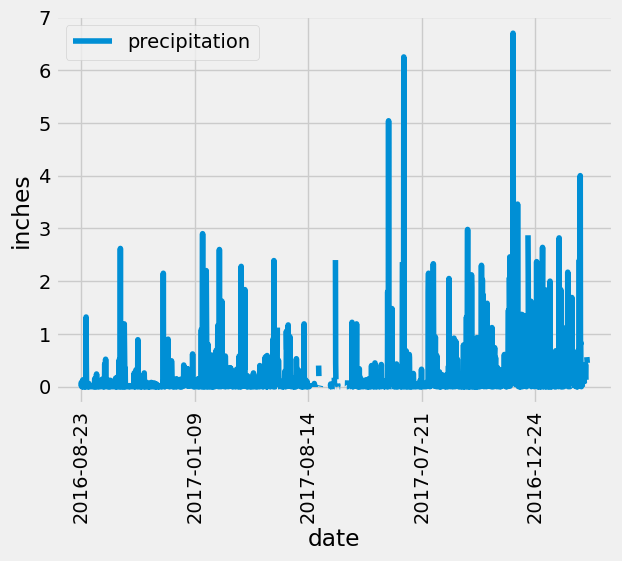

In [30]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_year_ago).all()

#Print
# for row in results:
#     print(row)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
results_df = pd.DataFrame(results)
results_df.rename(columns = {'prcp': 'precipitation'}, inplace =True)

# results_df.set_index('date', inplace = True)

# Sort the dataframe by date
sorted_results_df = results_df.groupby(['date'])['precipitation']

# Use Pandas Plotting with Matplotlib to plot the data

results_df.plot(x='date', y='precipitation', rot=90)

plt.ylabel('inches')

plt.show()


In [31]:
# Use Pandas to calculate the summary statistics for the precipitation data
sorted_results_count = results_df ['precipitation'].count()
sorted_results_mean = results_df['precipitation'].mean()
sorted_results_std = results_df['precipitation'].std()
sorted_results_min = results_df['precipitation'].min()
quartiles = results_df['precipitation'].quantile([.25, .5, .75])
lowerq = quartiles[.25]
middleq = quartiles[.5]
upperq = quartiles[.75]
sorted_results_max =  results_df['precipitation'].max()

stat_summary = pd.DataFrame({"count":sorted_results_count, "mean":sorted_results_mean,"std":sorted_results_std, "min":sorted_results_min,
                             "25%": lowerq, "50%":middleq, "75%":upperq, "max":sorted_results_max}, index=['precipitation']).T
stat_summary

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [32]:
# Design a query to calculate the total number of stations in the dataset
total_number = session.query(func.count(station.station)).scalar()
total_number
total_number = [func.count(station.station)]
total = session.query(*total_number).all()
total

[(9,)]

In [33]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

active_station =(session.query(measurement.station, func.count(measurement.station)).
                 group_by(measurement.station).
                 order_by(func.count(measurement.station).desc()).all())
for station, count in active_station:
    print({station} , {count})


{'USC00519281'} {2772}
{'USC00519397'} {2724}
{'USC00513117'} {2709}
{'USC00519523'} {2669}
{'USC00516128'} {2612}
{'USC00514830'} {2202}
{'USC00511918'} {1979}
{'USC00517948'} {1372}
{'USC00518838'} {511}


In [34]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
calc_temp = [measurement.station, 
             func.avg(measurement.tobs),
             func.max(measurement.tobs),
             func.min(measurement.tobs)]
max_station_temp = session.query(*calc_temp).\
    filter(measurement.station == 'USC00519281').all()
max_station_temp
            

[('USC00519281', 71.66378066378067, 85.0, 54.0)]

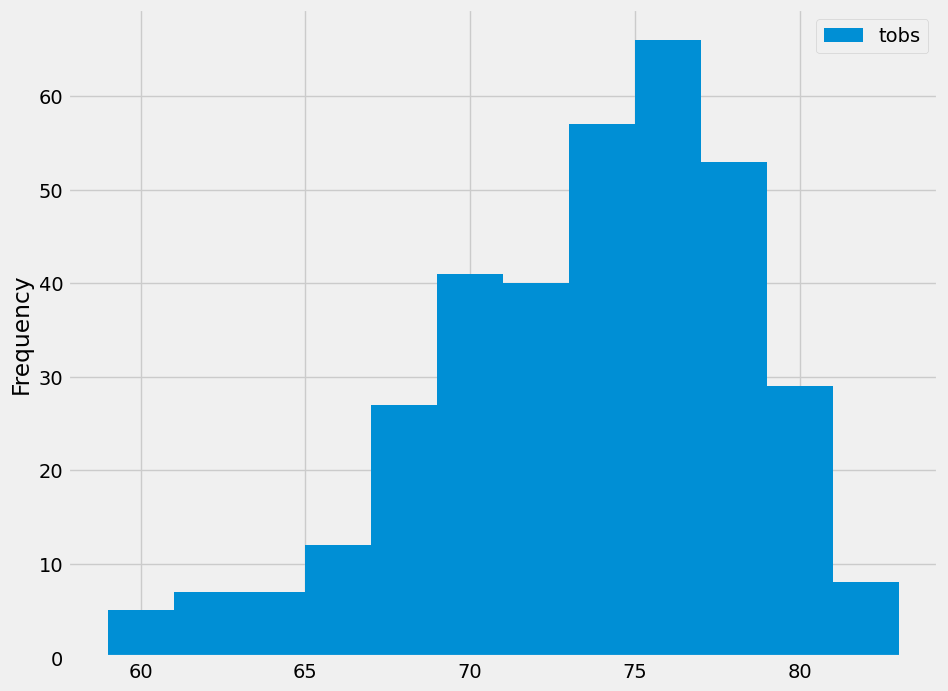

In [35]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
temp = session.query(measurement.date, measurement.station, measurement.tobs).\
        filter(measurement.date >= one_year_ago).filter(measurement.station == 'USC00519281').all()

temp_df = pd.DataFrame(temp)
temp_df.set_index('date', inplace = True)
temp_df.plot.hist(column=['tobs'],bins = 12, figsize=(10, 8) )

plt.show()

## Close Session

In [18]:
# Close Session
session.close()